<a href="https://colab.research.google.com/github/marcostranisci/UnderRepresentedWritersProject/blob/main/URW_modsem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
!pip3 install wikidata

In [ ]:
from wikidata.client import Client
import requests

## 1. Scaricare i dati da Wikidata

scarica i dati da Wikidata tramite query sparql

In [ ]:
url ='https://query.wikidata.org/sparql'

q = '''
SELECT DISTINCT ?author ?pob ?dob ?site
WHERE 
{
   {?author wdt:P106 wd:Q6625963} UNION {?author wdt:P106 wd:Q49757} UNION {?author wdt:P106 wd:Q36180}.
  ?author wdt:P19 ?pob;
          wdt:P569 ?dob.
   ?site   schema:about ?author;
          schema:isPartOf <https://en.wikipedia.org/>.

  FILTER(YEAR(?dob) > 1808)
}
'''
params = {'format':'json','query':q}
req = requests.get(url,params=params)

print('There are {} entities matching the SPARQL query'.format(len(req.json()['results']['bindings'])))
print('Here\'s the first entity: {}'.format(req.json()['results']['bindings'][0]))

wiki_id = req.json()['results']['bindings'][0]['author']['value'].split('/')[-1]
author_site = req.json()['results']['bindings'][0]['site']['value']
pobID = req.json()['results']['bindings'][0]['pob']['value'].split('/')[-1]



There are 75079 entities matching the SPARQL query
Here's the first entity: {'author': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q53672'}, 'pob': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q990775'}, 'dob': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime', 'type': 'literal', 'value': '1962-01-02T00:00:00Z'}, 'site': {'type': 'uri', 'value': 'https://en.wikipedia.org/wiki/Mo_Hayder'}}


chiama un'entità di Wikidata tramite il suo id e ispeziona tutte le proprietà con cui è associata

In [ ]:
wiki_id = req.json()['results']['bindings'][0]['author']['value'].split('/')[-1]
wiki_client = Client()
entity = wiki_client.get(wiki_id,load=True)

print(list(entity.items()))

[(<wikidata.entity.Entity P21>, <wikidata.entity.Entity Q6581072>), (<wikidata.entity.Entity P244>, 'n99036062'), (<wikidata.entity.Entity P227>, '123643228'), (<wikidata.entity.Entity P31>, <wikidata.entity.Entity Q5>), (<wikidata.entity.Entity P646>, '/m/0b0pn6'), (<wikidata.entity.Entity P569>, datetime.date(1962, 1, 2)), (<wikidata.entity.Entity P19>, <wikidata.entity.Entity Q990775>), (<wikidata.entity.Entity P27>, <wikidata.entity.Entity Q145>), (<wikidata.entity.Entity P106>, <wikidata.entity.Entity Q36180>), (<wikidata.entity.Entity P1006>, '187350760'), (<wikidata.entity.Entity P166>, <wikidata.entity.Entity Q833154>), (<wikidata.entity.Entity P69>, <wikidata.entity.Entity Q3091754>), (<wikidata.entity.Entity P856>, 'http://www.mohayder.net'), (<wikidata.entity.Entity P2163>, '1549369'), (<wikidata.entity.Entity P648>, 'OL21020A'), (<wikidata.entity.Entity P1411>, <wikidata.entity.Entity Q2336530>), (<wikidata.entity.Entity P349>, '00902027'), (<wikidata.entity.Entity P3417>, 

In [ ]:
for el in entity.items():

  print('property {} has label {}, and value {}'.format(el[0].id,el[0].label,el[1]))

property P21 has label sex or gender, and value <wikidata.entity.Entity Q6581072>
property P244 has label Library of Congress authority ID, and value n99036062
property P227 has label GND ID, and value 123643228
property P31 has label instance of, and value <wikidata.entity.Entity Q5>
property P646 has label Freebase ID, and value /m/0b0pn6
property P569 has label date of birth, and value 1962-01-02
property P19 has label place of birth, and value <wikidata.entity.Entity Q990775>
property P27 has label country of citizenship, and value <wikidata.entity.Entity Q145>
property P106 has label occupation, and value <wikidata.entity.Entity Q36180>
property P1006 has label Nationale Thesaurus voor Auteurs ID, and value 187350760
property P166 has label award received, and value <wikidata.entity.Entity Q833154>
property P69 has label educated at, and value <wikidata.entity.Entity Q3091754>
property P856 has label official website, and value http://www.mohayder.net
property P2163 has label FAST

stampa la label e la description di un'entità

In [ ]:
author_label = entity.label
description = entity.description

print('In Inglese: {} is a {}'.format(author_label['en'],description['en']))
print('In Italiano: {} è uno {}'.format(author_label['it'],description['it']))

recupera lo stato di nascita dell'autore

In [ ]:
pobID = req.json()['results']['bindings'][0]['pob']['value'].split('/')[-1]
placeOfBirth = wiki_client.get(pobID,load=True)
p17 = Client().get('p17')
country = placeOfBirth[p17].label

print('{} was born in {}, {}'.format(author_label,placeOfBirth.label,country))

## 2. Manipolare le biografie da Wikipedia

cose banali contro cui andare a sbattere: i contenuti delle pagine di Wikipedia non sono indentate

In [ ]:
import re
from bs4 import BeautifulSoup
import requests

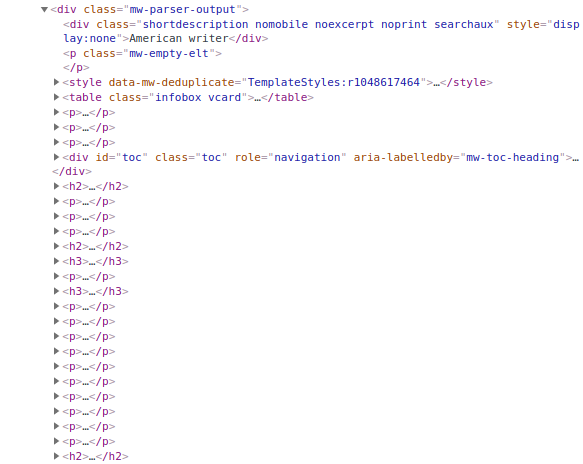

In [ ]:
author_site = 'https://en.wikipedia.org/wiki/Chimamanda_Ngozi_Adichie'

testo = str()
req = requests.get(author_site)
soup = BeautifulSoup(req.text,'html.parser')
for el in soup.find_all('p'):
  testo+=el.text
testo = re.sub(r'\[.*?\]','',testo)
testo = testo.replace('\n',' ')

print(testo)



Estrarre le entità di tipo GPE e ORG dal testo

In [ ]:
import spacy
import re

nlp = spacy.load('en_core_web_sm')


tokenized = nlp(testo)

orgs = {x.text.lower() for x in tokenized.ents if x.label_ =='ORG' and x.text!='Adichie' }

locs = {x.text.lower() for x in tokenized.ents if x.label_ =='GPE'}

orgs_pattern = re.compile(' '+"|".join(orgs)+' ')
locs_pattern = re.compile(' '+"|".join(locs)+' ')

preproc_text = re.sub(locs_pattern,'GPE ',testo.lower())
preproc_text = re.sub(orgs_pattern,'ORG ',preproc_text)

print(preproc_text)







Estrae i pattern dal testo

In [ ]:
tokenized_preprocessed = nlp(preproc_text)


for sent in tokenized_preprocessed.sents:
  
  Migration = re.search('(?=.*leave|left)(?=.*for GPE).*',sent.text)
  TimeIndexedPersonStatus = re.search('(?=.*receive)(?=.*from\sORG).*',sent.text)
  if Migration is not None:
    print('Migration pattern(s): {}'.format(Migration.group()))
  if TimeIndexedPersonStatus is not None:
    print('Time Indexed Person pattern(s): {}'.format(TimeIndexedPersonStatus.group()))

### Esempio di Time Indexed Person Status

[ a urw:Migration;\
>dul:isSettingFor [
>>a urw:ConditionRole;\
dul:isDefinedIn Study_Abroad\
dul:isRoleOf Q230141.\
]

> Q230141 a Person; \
skos:label 'Chimamanda Ngozi Adichie'.

>dul:isSettingFor USA;\
dul:isSetting For Q230141;\
prov:qualifiedDerivation [
>>prov:WasDerivedFrom https://en.wikipedia.org/wiki/Chimamanda_Ngozi_Adichie \
              ]

>prov:qualifiedAttribution [
>>prov:wasAttributedTo [
  >>> a LexicoSemanticPattern
  urw:hasPattern (escape-51.1-1)(to|at|in)(GPE|ORG)\
]

>>]

##3. Ispezionare e inserire classi e individui nell'ontologia

In [1]:
!pip install owlready2
!pip install rdflib

     |████████████████████████████████| 23.8 MB 1.5 MB/s 
  Created wheel for owlready2: filename=Owlready2-0.35-cp37-cp37m-linux_x86_64.whl size=20432792 sha256=51025460958729fd72b8ee65da9c81f9e922c81c8122493b2bc739e6c806f57a
  Stored in directory: /root/.cache/pip/wheels/a6/85/8f/4f254dc1d3b7901c23004544f7214748607d8b0c2c02b3c868
Successfully built owlready2
     |████████████████████████████████| 407 kB 7.5 MB/s 
     |████████████████████████████████| 45 kB 4.2 MB/s 


importare l'ontologia

In [3]:
import owlready2
import rdflib
import types
#ASSICURARSI CHE L'ONTOLOGIA SIA NELLA CARTELLA 'sample_data'. IN CASO CONTRARIO, CARICARLA NELLA CARTELLA
onto_file = owlready2.get_ontology('/content/sample_data/urw_ontology.owl')
onto = onto_file.load()

Ispeziona individuals

In [4]:
for individual in list(onto.individuals())[:10]:
  print(individual)

urw_ontology.Africa
urw_ontology.Asia
urw_ontology.Europe
urw_ontology.LatinAmericaAndCaribbean
urw_ontology.NorthAmerica
urw_ontology.Oceania
urw_ontology.ABW
urw_ontology.AFG
urw_ontology.AGO
urw_ontology.ALB


ispeziona classi

In [5]:
for class_ in onto.classes():
  print(class_)

owl.Thing
22-rdf-syntax-ns.langString
urw_ontology.Person
urw_ontology.Country
urw_ontology.Place
ontolex.LexicalEntry
ontolex.Form
urw_ontology.Migration
urw_ontology.TimeIndexedPersonStatus
ontolex.LexicalConcept
ontolex.LexicalSense
prov.ActivityInfluence
prov.Activity
prov.AgentInfluence
prov.Agent
prov.EntityInfluence
terms.DCMIType
prov.Association
prov.Attribution
prov.Derivation
prov.Generation
urw_ontology.Event
urw_ontology.Situation
urw_ontology.ConditionRole
urw_ontology.MigrationRole
urw_ontology.Migrating
urw_ontology.Classification
urw_ontology.TimeInterval
urw_ontology.MigrationPlan
urw_ontology.Description
urw_ontology.AssociationRole
dcmitype.Collection
dcmitype.Dataset
dcmitype.Event
dcmitype.Image
dcmitype.InteractiveResource
dcmitype.MovingImage
dcmitype.PhysicalObject
dcmitype.Service
dcmitype.Software
dcmitype.Sound
dcmitype.StillImage
dcmitype.Text
urw_ontology.Role
urw_ontology.Condition
urw_ontology.Continent
urw_ontology.CountryWithHighHDI
urw_ontology.Countr

Crea una classe

In [6]:
with onto:
  City = types.new_class('City', (onto['Place'],))

print(City)

urw_ontology.City


Crea entità e associale tramite proprietà

In [7]:
#CREA L'ENTITÀ
leini = onto['City']('Leini')
marco = onto['Person']('Q1985')


#CHIAMA L'ENTITÀ
print(onto['Leini'])
print(onto['Q1985'])


urw_ontology.Leini
urw_ontology.Q1985


Associa entità tramite proprietà

In [8]:
#ASSOCIA ENTITÀ TRAMITE PROPRIETÀ NON FUNZIONALI
onto['Leini'].isPartOf.append(onto['ITA'])

#ASSOCIA ENTITÀ TRAMITE PROPRIETÀ FUNZIONALI
onto['Q1985'].countryOfBirth= onto['ITA']

#ASSOCIA UNA LABEL A UN'ENTITÀ
onto['Q1985'].label.append(owlready2.locstr('Marco Antonio Stranisci','en'))

print(onto['Leini'].isPartOf)
print(onto['Q1985'].countryOfBirth)
print(onto['Q1985'].label)


[urw_ontology.ITA]
urw_ontology.ITA
['Marco Antonio Stranisci']


Un esempio (STUPIDO) di Time Indexed Person Status

In [27]:
# CREA UNA MIGRATION
bnode = rdflib.BNode()

Tips= onto['Migration'](bnode)

Tips.isSettingFor.append(onto['Q1985'])
Tips.isSettingFor.append(onto['Leini'])
Tips.timeValue.append(1990)

print('The Migration (blank node: {}) is setting for {} and is setting for {} in {}'.format(Tips.name,Tips.isSettingFor[0].label[0],Tips.isSettingFor[1].name,Tips.timeValue[0]))


The Migration (blank node:N0479456111824f46a8bd1b46b182ca16) is setting for Marco Antonio Stranisci and is setting for Leini in 1990
